In [3]:
import pickle
import numpy as np
import pandas as pd
import re
import networkx

In [4]:
import matplotlib.pyplot as plt
import bokeh as bk
from networkx.drawing.nx_agraph import graphviz_layout
from bokeh.models import ColumnDataSource
import bokeh.plotting 
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes, StaticLayoutProvider
from bokeh.palettes import Spectral4, Spectral8, Paired8

In [5]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.neighbors import NearestNeighbors

In [6]:
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

In [7]:
def matplot(distribution): 
    plt.scatter(np.arange(len(distribution)), distribution)
    plt.show()

In [8]:
def bokeh_plot(data_in, num_points, x_col, y_col, title, tooltips):
    shuffle = np.random.permutation(data_in.shape[0])
    data_rdm = data_in.loc[shuffle[:num_points], :].copy()
    output_notebook()
    plot_tfidf = bk.plotting.figure(plot_width=700, plot_height=600, title=title,
        tools="pan, wheel_zoom, box_zoom, reset, hover, previewsave",
        x_axis_type=None, y_axis_type=None, min_border=1)
    plot_tfidf.scatter(x=x_col, y=y_col, source=data_rdm)
    hover = plot_tfidf.select(dict(type=HoverTool))
    hover.tooltips=tooltips
    show(plot_tfidf)

In [9]:
def pca_plot(df, mat, n_components):
    if n_components < 2: raise ValueError('Needs to be > 3 components')
    ursvd = PCA(n_components=10)
    ursvd_res = ursvd.fit_transform(mat)
    df['pca-one'] = ursvd_res[:,0]
    df['pca-two'] = ursvd_res[:,1] 
    df['pca-three'] = ursvd_res[:,2]
    print('Variation per principal component: {}'.format(ursvd.explained_variance_ratio_))
    bokeh_plot(df, 4000, 'pca-one', 'pca-two', 'PCA Clustering', {"title": "@title", "authors":"@authors"})

In [10]:
data_original = pd.read_csv('./pickles/data_pd.csv')

##### Distribution of summary lengths

1066.30492214
26
3871
362.949552699


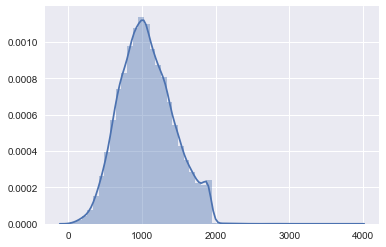

In [11]:
summaries = data_original['summary'].values
lengths = np.array([len(i) for i in summaries])
print(np.mean(lengths))
print(np.min(lengths))
print(np.max(lengths))
print(np.sqrt(np.var(lengths)))
sns.distplot(lengths)

In [12]:
data_corpus = pickle.load(file=open('./pickles/mallet_doc_corpus.pickle', 'rb'))

In [13]:
data_original.head()

,Unnamed: 0,title,summary,date,authors,tags,id
0,0,Minimax deviation strategies for machine learn...,The article is devoted to the problem of small...,1500196508,"['Michail Schlesinger', 'Evgeniy Vodolazskiy']",['cs.LG'],1707.04849v1
1,1,mlbench: How Good Are Machine Learning Clouds ...,We conduct an empirical study of machine learn...,1501365558,"['Hantian Zhang', 'Luyuan Zeng', 'Wentao Wu', ...","['cs.DC', 'cs.LG', 'stat.ML']",1707.09562v2
2,2,Introduction to Machine Learning: Class Notes ...,Introduction to Machine learning covering Stat...,1240486857,['Amnon Shashua'],['cs.LG'],0904.3664v1
3,3,AutoCompete: A Framework for Machine Learning ...,"In this paper, we propose AutoCompete, a highl...",1436368059,"['Abhishek Thakur', 'Artus Krohn-Grimberghe']","['stat.ML', 'cs.LG']",1507.02188v1
4,4,Joint Training of Deep Boltzmann Machines,We introduce a new method for training deep Bo...,1355277567,"['Ian Goodfellow', 'Aaron Courville', 'Yoshua ...","['stat.ML', 'cs.LG']",1212.2686v1


## Preprocess Topic Data

In [14]:
topic_words = pickle.load(file = open('./pickles/mallet_learnt_topics.pickle', 'rb'))

In [15]:
topic_words[0]

(0,
 [('however,', 0.11407316),
  ('and,', 0.054866709),
  ('therefore,', 0.051456913),
  ('difficult', 0.042467453),
  ('typically', 0.04184749),
  ('thus,', 0.038437694),
  ('paper,', 0.037817731),
  ('requires', 0.034717917),
  ('numerous', 0.023248605),
  ('moreover,', 0.023248605),
  ('generally', 0.01983881),
  ('hence,', 0.019528829),
  ('unfortunately,', 0.018598884),
  ('highly', 0.018288903),
  ('suitable', 0.017048977)])

In [18]:
#Get Topics
topic_words = pickle.load(file=open('./pickles/mallet_learnt_topics.pickle','rb'))
topics = [0]*len(topic_words)
i = 0
for topic in topic_words:
    topics[i] = np.array(topic[1])[:, 0]
    i+=1
print(len(topics), 'Input topics')

#Augment Vector if Required
data_in = data_corpus[:]
data_agg = np.zeros(np.shape(data_in)[1])
threshold = 0.10
min_score = 1
threshold_prob = 0.01

#Set baseline threshold for entire corpus
print('Setting topic threshold at', threshold)
for paper in data_in:
    chk = paper[paper > threshold]
    data_agg = np.add(data_agg, (paper > threshold).astype(int))
prune = (data_agg >= min_score).astype(int) #Stuff to keep
idx_arr = np.arange(np.shape(data_in)[1])

idx_arr = idx_arr[prune == 0]
#Clean corresponding topics
for i in reversed(idx_arr):
    del(topics[i])
    del(topic_words[i])
    
data_in = data_in[:, prune == 1]
print('Pruned to', len(topics), 'topics')

#Remove near-zero values
data_in[data_in < threshold_prob] = 0
print('Zeroing any values below', threshold_prob)

#Sum to 1?
sum_one = np.sum(data_in, axis = 1)
sum_one[sum_one == 0] = 1 #Resolve any 0 errors

data_in = data_in/sum_one[:,None]

# data_in = StandardScaler().fit_transform(data_in)
# print('Normalised to zero-mean and unit variance')
# OR
# data_in = np.subtract(data_in, np.min(data_in, axis = 0))/(np.max(data_in, axis = 0) - np.min(data_in, axis = 0))
# print('Max-min normalised')
# sns.distplot(data_in[:, 5])
#data_in = np.subtract(data_in, np.mean(data_in, axis = 0))/np.var(data_in, axis = 0)

750 Input topics
Setting topic threshold at 0.1
Pruned to 598 topics
Zeroing any values below 0.01


In [22]:
for topic in topics:
    print(topic)

['brain' 'functional' 'imaging' 'connectivity' 'magnetic' 'fmri'
 'cognitive' 'neuroimaging' 'human' 'resonance' 'analysis' 'activity'
 'subjects' 'studies' 'data']
['fault' 'monitoring' 'failure' 'machine' 'systems' 'tolerance'
 'maintenance' 'failures' 'execution' 'high' 'faults' 'distributed'
 'replication' 'ensure' 'reliable']
['candidate' 'set' 'results' 'candidates' 'find' 'select' 'selecting'
 'selected' 'good' 'approach' 'promising' 'pool' 'ideal' 'propose'
 'identify']
['social' 'media' 'twitter' 'users' 'information' 'tweets' 'online'
 'content' 'user' 'facebook' 'public' 'posts' 'media.' 'tweet' 'accounts']
['polynomial' 'time' 'problem' 'give' 'exponential' 'algorithm' 'hardness'
 'result' 'complexity' 'time.' 'constant' 'bounded' 'hard' 'prove' 'number']
['cloud' 'computing' 'service' 'management' 'services' 'resources'
 'infrastructure' 'applications' 'grid' 'resource' 'deployment'
 'distributed' 'execution' 'virtual' 'services.']
['energy' 'consumption' 'power' 'demand' 

In [32]:
pickle.dump(file=open('./pickles/topics_pruned.pickle', 'wb'), obj = topics)

In [33]:
pickle.dump(file=open('./pickles/paper_dist_pruned.pickle', 'wb'), obj = data_in)

### Other Post-Preprocessing Options

#### Approach 1, Topic-wise normalise (Val - Mean)/Var

In [13]:
data_norm = data_in[:]
data_norm = np.subtract(data_norm, np.mean(data_norm, axis = 0))/np.var(data_norm, axis = 0)

#### Approach 2, Max-Min Normalisation

In [15]:
data_maxmin = data_in[:]
data_maxmin = np.subtract(data_maxmin, np.min(data_maxmin, axis = 0))/(np.max(data_maxmin, axis = 0) - np.min(data_maxmin, axis = 0))

## Construct User Vectors

In [15]:
pattern = re.compile('([^\s\w]|_)+')
user_map = {}
users_raw = data_original['authors'].values
users_cleaned = [] #List of authors for each paper
for idx, authors in enumerate(users_raw):
    authors = authors.split(',')
    clean_authors = []
    for author in authors:
        author = pattern.sub('', author)
        author = author.strip()
        clean_authors.append(author)
        author = author.lower()
        if author in user_map:
            user_map[author].append(idx)
        else:
            user_map[author] = [idx]
    users_cleaned.append(clean_authors)

In [16]:
pickle.dump(file = open('./pickles/user_mappings.pickle', 'wb'), obj=user_map)

In [17]:
print(user_map['aniruddh raghu'])

[17060]


In [18]:
def build_user_var(user_map_in, data_in_to): 
    user_research = np.zeros((len(user_map_in.keys()), np.shape(data_in_to)[1]))
    user_id_map = {} #hash of author names to author index in superlist (not related to users_cleaned above)
    user_id_map_reverse = {} #hash of author index to author names
    i = 0
    for author in user_map_in.keys():
        blank = np.zeros((np.shape(data_in_to)[1]))
        user_id_map[author] = i
        user_id_map_reverse[i] = author
        for paper in user_map_in[author]:
            blank = np.add(blank, data_in_to[paper])
        user_research[i] = blank
        i+=1
    return ((user_id_map, user_id_map_reverse) , user_research)

In [19]:
    def paper_author_id_mappings(paper_to_author, author_to_id):
        paper_to_id = []
        for paper in paper_to_author:
            paper_ids = []
            for author in paper:
                paper_ids.append(author_to_id[author.lower()])
            paper_to_id.append(paper_ids)
        return paper_to_id

In [20]:
papers = data_original['title'].values
user_map_name = {}
for key in user_map.keys():
    lst = [papers[p_id] for p_id in user_map[key]]
    user_map_name[key] = lst

In [21]:
#Compute user arrays
user_id_map, user_research = build_user_var(user_map, data_in)
papauth_id = paper_author_id_mappings(users_cleaned, user_id_map[0])

#user_map - Author name -> paper IDs
#user_map_name - Author name -> paper names
#user_id_map[0] - Author name -> ID
#user_id_map[1] - ID -> Author name
#user_research - A summed list of topic  
#papauth_id - paper ID to author IDs
#users_cleaned - paper ID to author name

In [22]:
pickle.dump(file = open('./pickles/auth_paper_title.pickle', 'wb'), obj = user_map_name)

In [23]:
pickle.dump(file=open('./pickles/user_research_data.pickle', 'wb'), obj = user_research)

In [24]:
pickle.dump(file = open('./pickles/user_id_maps.pickle', 'wb'), obj = user_id_map)

In [25]:
pickle.dump(file = open('./pickles/paper_auth_id.pickle', 'wb'), obj = papauth_id)

In [26]:
pickle.dump(file = open('./pickles/paper_auth_name.pickle', 'wb'), obj = users_cleaned)

## Nearest Neighbours

### On Authors

In [27]:
user_id_map = pickle.load(file = open('./pickles/user_id_maps.pickle', 'rb'))

In [28]:
user_research = pickle.load(file=open('./pickles/user_research_data.pickle', 'rb'))

In [29]:
nbrs_dep = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(user_research) #Experience Dependent

In [30]:
def compute_for_author(author, id_map, user_profile, neighbour):
    distances, indices = neighbour.kneighbors(user_profile[id_map[0][author.lower()]].reshape(1, -1))
    for idx, i in enumerate(indices):
        for j in i:
            print(id_map[1][j])

In [31]:
compute_for_author('David Sontag', user_id_map, user_research, nbrs_dep)

david sontag
edward choi
david c kale
walter f stewart
scott hu
jinsung yoon
suchi saria
mohammad taha bahadori
andy schuetz
peter szolovits


In [26]:
compute_for_author('Yann lecun', user_id_map, user_research, nbrs_dep)

yann lecun
joan bruna
michael mathieu
arthur szlam
andrew zisserman
rob fergus
roberto cipolla
eugenio culurciello
edouard oyallon
amnon shashua


### On Papers

In [26]:
nbrs_papers = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(data_in)

In [27]:
def compute_for_paper(search_term, data_proc, data_orig, paper_author_map, id_map, neighbour):
    res = [i for i in enumerate(data_orig['title'].values) if search_term.lower() in i[1].lower()]
    for result in res:
        print('Results for:', result[1], ' by:', paper_author_map[result[0]])
        print('--------')
        distances, indices = neighbour.kneighbors(data_proc[result[0]].reshape(1, -1))
        for i in indices:
            for j in i:
                print(data_orig.iloc[j, :]['title'])
        print('--------')

In [28]:
compute_for_paper('Continuous State-Space Models for Optimal Sepsis Treatment', data_in, data_original, users_cleaned ,user_id_map, nbrs_papers)

Results for: Continuous State-Space Models for Optimal Sepsis Treatment - a Deep
  Reinforcement Learning Approach  by: ['Aniruddh Raghu', 'Matthieu Komorowski', 'Leo Anthony Celi', 'Peter Szolovits', 'Marzyeh Ghassemi']
--------
Continuous State-Space Models for Optimal Sepsis Treatment - a Deep
  Reinforcement Learning Approach
A Reinforcement Learning Approach to Weaning of Mechanical Ventilation
  in Intensive Care Units
A Naive Bayes machine learning approach to risk prediction using
  censored, time-to-event data
Sparse Multi-Output Gaussian Processes for Medical Time Series
  Prediction
DeepSurv: Personalized Treatment Recommender System Using A Cox
  Proportional Hazards Deep Neural Network
Identifying Diabetic Patients with High Risk of Readmission
Personalized Risk Scoring for Critical Care Patients using Mixtures of
  Gaussian Process Experts
DeepCare: A Deep Dynamic Memory Model for Predictive Medicine
Personalized Risk Scoring for Critical Care Prognosis using Mixtures of


In [29]:
compute_for_paper('Wasserstein GAN', data_in, data_original, users_cleaned ,user_id_map, nbrs_papers)

Results for: Wasserstein GAN  by: ['Martin Arjovsky', 'Soumith Chintala', 'Léon Bottou']
--------
Wasserstein GAN
Improved Training of Wasserstein GANs
Generative Models and Model Criticism via Optimized Maximum Mean
  Discrepancy
Annealed Generative Adversarial Networks
Generating images with recurrent adversarial networks
Submodular Mini-Batch Training in Generative Moment Matching Networks
Learning a regression function via Tikhonov regularization
Differential Contrastive Divergence
A Machine-Learning Framework for Design for Manufacturability
Comments on `High-dimensional simultaneous inference with the bootstrap'
--------
Results for: Improved Training of Wasserstein GANs  by: ['Ishaan Gulrajani', 'Faruk Ahmed', 'Martin Arjovsky', 'Vincent Dumoulin', 'Aaron Courville']
--------
Improved Training of Wasserstein GANs
Gradient descent GAN optimization is locally stable
Generating images with recurrent adversarial networks
Adversarial Ranking for Language Generation
Probabilistic Gene

### K-Means

In [30]:
from sklearn.cluster import KMeans
num_clusters = 1500
k_m = KMeans(n_clusters=num_clusters, max_iter = 1000)
k_m.fit(data_in)
centers = k_m.cluster_centers_
assignments = k_m.labels_
sns.distplot(assignments)

KeyboardInterrupt: 

In [ ]:
reverse_assignments = [0]*num_clusters
for i in assignments:
    reverse_assignments[i] += 1
reverse_assignments = np.array(reverse_assignments)
print('Mean papers per cluster:', np.mean(reverse_assignments), '| Variance of papers per cluster: ', np.var(reverse_assignments))

In [ ]:
k_means_save = (centers, assignments, reverse_assignments)
pickle.dump(file = open('./pickles/kmeans_save.pickle', 'wb'), obj=k_means_save)

In [31]:
centers, assignments, reverse_assignments = pickle.load(file = open('./pickles/kmeans_save.pickle', 'rb'))

In [32]:
assignments_dict = {}
reverse_assignments_dict = {}
for idx in range(len(assignments)):
    assignments_dict[idx] = assignments[idx]
    if assignments[idx] in reverse_assignments_dict:
        reverse_assignments_dict[assignments[idx]].append(idx)
    else:
        reverse_assignments_dict[assignments[idx]] = [idx]

In [33]:
def display_for_cluster(search_term, dict_in, reverse_dict_in, data_orig, cluster_limit = 10):
    res = [i for i in enumerate(data_orig['title'].values) if search_term.lower() in i[1].lower()]
    prev_clusters = set()
    for result in res[:cluster_limit]:
        print('Results for:', result[1])
        print('--------')
        clust = dict_in[result[0]]
        if clust not in prev_clusters:
            prev_clusters.add(clust)
            for idxes in reverse_dict_in[clust]:
                print(data_orig.iloc[idxes, :]['title'])
        else:
            print('Cluster already printed')
        print('--------')

In [34]:
display_for_cluster('Convolutional Neural Networks', assignments_dict, reverse_assignments_dict, data_original)

Results for: Churn analysis using deep convolutional neural networks and autoencoders
--------
Churn analysis using deep convolutional neural networks and autoencoders
Morpheo: Traceable Machine Learning on Hidden data
Revealed Preference at Scale: Learning Personalized Preferences from
  Assortment Choices
Contextual Markov Decision Processes
Learning with Changing Features
A Deep Causal Inference Approach to Measuring the Effects of Forming
  Group Loans in Online Non-profit Microfinance Platform
GaDei: On Scale-up Training As A Service For Deep Learning
Large-Scale Detection of Non-Technical Losses in Imbalanced Data Sets
Predicting Near-Future Churners and Win-Backs in the Telecommunications
  Industry
An expert system for detecting automobile insurance fraud using social
  network analysis
On Detecting Messaging Abuse in Short Text Messages using Linguistic and
  Behavioral patterns
Exploiting Big Data in Logistics Risk Assessment via Bayesian
  Nonparametrics
Model-based Dashboar

In [37]:
for idx, k in enumerate(assignments):
    if k == 890:
        print(data_original.iloc[idx, :]['title'])

Safe and Efficient Screening For Sparse Support Vector Machine
Taking Advantage of Sparsity in Multi-Task Learning
Safe Screening With Variational Inequalities and Its Application to
  LASSO
An Efficient Approach to Sparse Linear Discriminant Analysis
A Component Lasso
Nonparametric Independence Screening in Sparse Ultra-High Dimensional
  Additive Models
Efficient Feature Screening for Lasso-Type Problems via Hybrid
  Safe-Strong Rules
Localized Lasso for High-Dimensional Regression
Multi-stage Convex Relaxation for Feature Selection
Quantile universal threshold: model selection at the detection edge for
  high-dimensional linear regression
Exploring Sparsity in Multi-class Linear Discriminant Analysis
Elastic Net Procedure for Partially Linear Models
Structured variable selection in support vector machines
Compound Poisson Processes, Latent Shrinkage Priors and Bayesian
  Nonconvex Penalization
Selective Factor Extraction in High Dimensions
Lasso and equivalent quadratic penalized mo

### GMM/EM 
##### N_components = 300: Doesn't work - posteriors are all 1. Eventually converged to K-Means equivalent solution

In [ ]:
from sklearn.mixture import GaussianMixture
e_m = GaussianMixture(n_components = 300, max_iter = 130, verbose = 2)
e_m.fit(data_in)

In [ ]:
posterior = e_m.predict_proba(data_in)

### Build paper graph

### Build author graph

In [140]:
import bokeh as bk
from networkx.drawing.nx_agraph import graphviz_layout
from bokeh.models import ColumnDataSource
import bokeh.plotting 
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes, StaticLayoutProvider
from bokeh.palettes import Spectral4, Spectral8, Paired8
import numpy as np
import pandas as pd

In [141]:
users_cleaned = pickle.load(file = open('./pickles/paper_auth_name.pickle', 'rb'))
users_id_map = pickle.load(file = open('./pickles/user_id_maps.pickle', 'rb'))
user_map = pickle.load(file = open('./pickles/user_mappings.pickle', 'rb'))

In [142]:
def author_graph(author, user_papers_map, papers_user_map, user_id_map, limit = 1000, depth = 5, cap_per_paper = 3):
    auths = {}
    if author.lower() in user_id_map[0]:
        to_do_q = []
        author_papers = user_papers_map[author.lower()]
        to_do_q.extend(zip(author_papers, [user_id_map[0][author.lower()]] * len(author_papers)))
        to_do_q.append('--')
        cur_depth = 0
        auths[user_id_map[0][author.lower()]] = (-1, user_id_map[0][author.lower()], cur_depth)
        done = set()
        while ((len(auths.keys()) < limit or len(to_do_q) == 0) and cur_depth <= depth):
            pop_paper = to_do_q[0]
            del[to_do_q[0]]
            if pop_paper in done: continue
            if pop_paper == '--':
                pop_paper = to_do_q[0]
                del[to_do_q[0]]
                to_do_q.append('--')
                cur_depth += 1
                print('Current depth:', cur_depth)
            else:
                done.add(pop_paper)
            colleagues = papers_user_map[pop_paper[0]]
            if len(colleagues) > cap_per_paper: colleagues = colleagues[:cap_per_paper]
            for colleague in colleagues:
                if not user_id_map[0][colleague.lower()] in auths:
                    auths[user_id_map[0][colleague.lower()]] =  (pop_paper[0], pop_paper[1], cur_depth + 1)
                colleague_papers = user_papers_map[colleague.lower()]
                to_do_q.extend(zip(colleague_papers, [user_id_map[0][colleague.lower()]] * len(colleague_papers)))
        if cur_depth > depth: print('Max depth reached')
        if len(auths.keys()) >= limit: print('Max limit reached')
        return auths
    else:
        print('Author', author, 'not found')
        return None

In [143]:
auths = author_graph('David Sontag', user_map, users_cleaned, user_id_map, 100, 4)

Current depth: 1
Max limit reached


#### Render Graph

In [144]:
bokeh.plotting.output_notebook()

Loading BokehJS ...

In [145]:
from bokeh.models.tools import *

In [146]:
keys = list(auths.keys())
colours = [0]*len(keys)
names = [user_id_map[1][idx].title() for idx in keys]
papers = [0]*len(keys)
search = ""
G = networkx.DiGraph()
G.add_nodes_from(keys)
root_node = 0
for idx, key in enumerate(keys):
    tag = auths[key]
    if not tag[0] == -1:
        G.add_edge(tag[1], key)
        papers[idx] = data_original.iloc[tag[0], :]['title']
    else:
        root_node = key
        papers[idx] = 'Input search query'
        search = names[idx]
    colours[idx] = Paired8[tag[2]]

In [147]:
pos = graphviz_layout(G, prog='twopi', root = root_node)
max_x = max([i[1][0] for i in pos.items()])
min_x = min([i[1][0] for i in pos.items()])
max_y = max([i[1][1] for i in pos.items()])
min_y = min([i[1][1] for i in pos.items()])

hover = bokeh.models.tools.HoverTool(tooltips=[("Author","@author"), ("Source","@source")])
plot = bokeh.plotting.figure(plot_width=1000, plot_height=1000, x_range=bokeh.models.ranges.Range1d(min_x - 20,max_x + 20),\
                             y_range=bokeh.models.ranges.Range1d(min_y - 20,max_y + 20),\
                             tools=[hover, bokeh.models.tools.PanTool(), bokeh.models.tools.WheelZoomTool(), \
                                    bokeh.models.tools.TapTool(), bokeh.models.tools.ResetTool()], \
                             title="Network Graph for " + search.title()
                            )

nodes = G.nodes()
edges = G.edges()
edges_start = [edge[0] for edge in edges]
edges_end = [edge[1] for edge in edges]
node_source = ColumnDataSource(data=dict(index= nodes, 
                                         fill_color = colours, 
                                         author = names, 
                                         source = papers))
edge_source = ColumnDataSource(data=dict(
                                        start=edges_start,
                                        end=edges_end
))
plot.xaxis.visible = False
plot.xgrid.visible = False
plot.yaxis.visible = False
plot.ygrid.visible = False

graph_renderer = bokeh.models.renderers.GraphRenderer()
graph_renderer.node_renderer.data_source.data = node_source.data
graph_renderer.node_renderer.glyph =  bokeh.models.Circle(size=15, fill_color="fill_color")
graph_renderer.node_renderer.selection_glyph =  bokeh.models.Circle(size=15, fill_color=Spectral8[2])
graph_renderer.edge_renderer.data_source.data = edge_source.data
graph_renderer.edge_renderer.glyph =  bokeh.models.MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
graph_renderer.edge_renderer.selection_glyph =  bokeh.models.MultiLine(line_color=Spectral4[2], line_width=5)
graph_renderer.layout_provider = StaticLayoutProvider(graph_layout=pos)

graph_renderer.selection_policy = NodesAndLinkedEdges()

plot.renderers.append(graph_renderer)
show(plot)

E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: fill_color [renderer: GlyphRenderer(id='e082f21b-2906-4253-afd9-3f5fbd8f9f0c', ...)]
